In [1]:
# sklearn version 0.19.0 or 0.19.1 required
# import sklearn
# sklearn.__version__
# python 3.0 recommended

from __future__ import division, print_function, unicode_literals
import numpy as np
import pandas as pd
import os
import timeit
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split #from model_selection instead of cross_validation
from sklearn.model_selection import validation_curve #from model_selection instead of learning_curve
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

certain portion of code was borrowed from "Hands-On Machine Learning with Scikit-Learn and TensorFlow" Book

In [147]:
# To plot pretty figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "classification"
DATASET_ID = "_housing_" # for red wine dataset

# Functions
def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, PROJECT_ID + DATASET_ID + fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
def plot_curve(sizes, data, dots=True, **kwargs):
    mu, std = data.mean(1), data.std(1)
    if dots:
        lines = plt.plot(sizes, mu, 'o-', **kwargs)
    else:
        lines = plt.plot(sizes, mu, '-', **kwargs)
    plt.fill_between(sizes, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.3)
    
def normalize_data(df, columns):
    for column in columns:
        mean_value = df.loc[:,column].mean()
        stdev = np.std(df.loc[:,column].values)
        df.loc[:,column] = (df.loc[:,column] - mean_value) / stdev
    return df

# Housing

In [3]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [ ]:
# # This version supports both Python 2 and Python 3, instead of just Python 3.
# def test_set_check(identifier, test_ratio, hash):
#     return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [9]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [10]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [11]:
train_set.head(10)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY,-122212.15
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY,-122212.16
7,7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY,-122212.16
9,9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY,-122212.16
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY,-122232.15


In [12]:
test_set.head(10)

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16
14,14,-122.26,37.85,52.0,2643.0,626.0,1212.0,620.0,1.9167,159200.0,NEAR BAY,-122222.15
15,15,-122.26,37.85,50.0,1120.0,283.0,697.0,264.0,2.1250,140000.0,NEAR BAY,-122222.15
18,18,-122.26,37.84,50.0,2239.0,455.0,990.0,419.0,1.9911,158700.0,NEAR BAY,-122222.16
38,38,-122.26,37.83,52.0,1470.0,330.0,689.0,309.0,3.4800,191400.0,NEAR BAY,-122222.17
39,39,-122.26,37.83,52.0,2432.0,715.0,1377.0,696.0,2.5898,176000.0,NEAR BAY,-122222.17


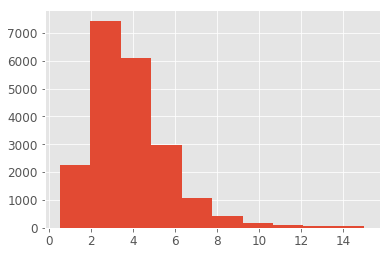

In [13]:
housing["median_income"].hist()

In [61]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [62]:
housing["income_cat"].value_counts()

3.0    5728
2.0    5210
4.0    2893
5.0    1871
1.0     652
Name: income_cat, dtype: int64

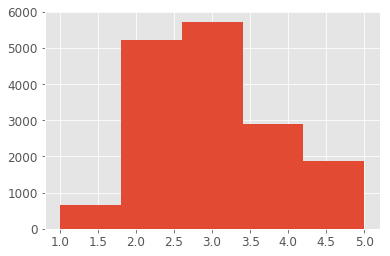

In [64]:
housing["income_cat"].hist(bins = 5)

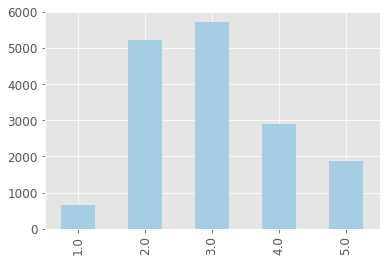

In [66]:
housing["income_cat"].value_counts().sort_index().plot(kind = 'bar', colormap='Paired')

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [23]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [24]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [25]:
compare_props

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [26]:
strat_train_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,2.0


In [27]:
strat_test_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN,5.0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN,4.0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN,3.0


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [29]:
strat_train_set.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN


In [30]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [48]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [52]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"], inplace=True)    # option 1

In [53]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [57]:
copy = strat_train_set.copy()
copy.dropna(subset=["total_bedrooms"], inplace=True) 
housing = copy.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = copy["median_house_value"].copy()

In [58]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [67]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [71]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0], dtype=int64)

In [72]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [74]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

<16354x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16354 stored elements in Compressed Sparse Row format>

In [75]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [76]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [80]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

<16354x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16354 stored elements in Compressed Sparse Row format>

In [81]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [82]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [86]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)]

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [87]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,2,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,5,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,2,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,2,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,3,4.50581,3.04785


In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [91]:
housing_num_tr.shape

(16354, 12)

In [92]:
housing_num.shape

(16354, 9)

In [94]:
housing_num.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,3.0
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,3.0
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,5.0
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,4.0
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,2.0
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,1.0


In [95]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [96]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [97]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [98]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.1562985 ,  0.77198428,  0.74387575, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17628181,  0.65973958, -1.16381502, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18674452, -1.3419575 ,  0.18746594, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.5864107 , -0.72461167, -1.5612506 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.7820825 , -0.85088695,  0.18746594, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43606483,  0.99647367,  1.85669537, ...,  0.        ,
         1.        ,  0.        ]])

since this binary dataset is well balanced, a simple accuracy calculation could do a good model evaluation job

https://tryolabs.com/blog/2013/03/25/why-accuracy-alone-bad-measure-classification-tasks-and-what-we-can-do-about-it/

In [102]:
housing_labels.values

array([ 286600.,  340600.,  196900., ...,   97800.,  225900.,  500001.])

In [131]:
X = housing_prepared
y = housing_labels.values

# Data normalization is important for ANN
# df = normalize_data(df, column_list) 
# df.describe().T
# X = df[column_list].values

# Data shuffling
X, y = shuffle(X, y, random_state=123)

# Data spliting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)
X_train_size = X_train.shape[0]

In [122]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [118]:
housing_prepared

array([[-1.1562985 ,  0.77198428,  0.74387575, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17628181,  0.65973958, -1.16381502, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18674452, -1.3419575 ,  0.18746594, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.5864107 , -0.72461167, -1.5612506 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.7820825 , -0.85088695,  0.18746594, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43606483,  0.99647367,  1.85669537, ...,  0.        ,
         1.        ,  0.        ]])

In [119]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
19480    127900.0
8879     500001.0
13685    140200.0
4937      95000.0
4861     500001.0
16365     92100.0
19684     61500.0
19234    313000.0
13956     89000.0
2390     123900.0
11176    197400.0
15614    500001.0
2953      63300.0
13209    107000.0
6569     184200.0
5825     280900.0
18086    500001.0
16718    171300.0
13600    116600.0
13989     60800.0
15168    121100.0
6747     270700.0
7398     109900.0
5562     159600.0
16121    500001.0
           ...   
12380    122500.0
5618     350000.0
10060    172800.0
18067    500001.0
4471     146600.0
19786     81300.0
9969     247600.0
14621    164100.0
579      254900.0
11682    185700.0
245      126800.0
12130    114200.0
16441    101800.0
11016    265600.0
19934     88900.0
1364     225000.0
1236     123500.0
5364     500001.0
11703    321600.0
10356    266000.0
15270    346700.0
3754     190200.0
12166    148800.0
6003     214800.0
7364     1

Saving figure Linear Regression Learning


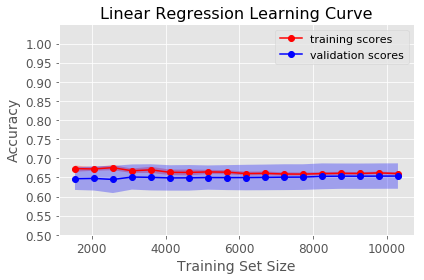

In [125]:
from sklearn.linear_model import LinearRegression

def plot_learning_curve_rg():
    train_sizes = np.linspace(0.15, 1, 18)
    N_train, val_train, val_test = learning_curve(LinearRegression(),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Linear Regression Learning Curve', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Linear Regression Learning', tight_layout=True)
    
plot_learning_curve_rg()

In [123]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
test_score = lin_reg.score(X_test, y_test)
print ('Decision Tree Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

Decision Tree Model Prediction Accuracy on Test Data: 0.6488


In [ ]:
 np.array(['Good Wine' if i>=6 else 'Bad Wine' for i in df['quality']])

In [137]:
test = np.array([5 if i>=2000000 else 4 if i > 1000000 else 3 if i > 500000 else 2 if i > 250000 else 1 for i in y_train])

# DecisionTreeClassifier

In [138]:
y_train = test

Saving figure Linear Regression Learning


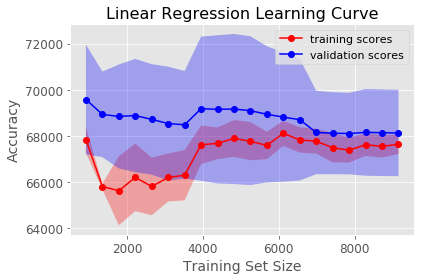

In [134]:
def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

# degree = np.arange(0, 18)
# val_train, val_test = validation_curve(DecisionTreeClassifier(), X, y,
#                                        'max_depth', depths, cv=10,
#                                        scoring=rms_error)
def plot_learning_curve_rg1():
    train_sizes = np.linspace(0.1, 1, 20)
    N_train, val_train, val_test = learning_curve(LinearRegression(),
                                                  X_train, y_train, train_sizes=train_sizes, cv=5, scoring=rms_error)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
#     plt.ylim(lower, upper+interval)
#     plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Linear Regression Learning Curve', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Linear Regression Learning', tight_layout=True)
    
plot_learning_curve_rg1()

Saving figure Decision Tree Complexity Curve (max_depth)


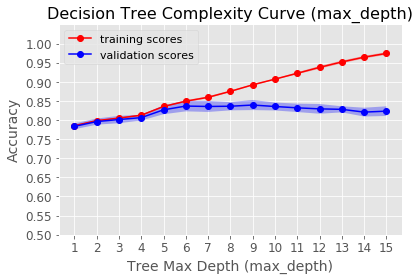

In [139]:
def plot_complexity_curve_dt():
    param_name="max_depth"
    param_range=range(1,16)
    val_train, val_test = validation_curve(DecisionTreeClassifier(random_state=0),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(param_range)
    plt.xlabel('Tree Max Depth (max_depth)'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Complexity Curve (max_depth)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Decision Tree Complexity Curve (max_depth)', tight_layout=True)
    
plot_complexity_curve_dt()

based on Decision Tree COmplexity Curve, max_depth = 10 is chosen for following Decision Tree analysis

Saving figure Decision Tree Learning Curve 1 (max_depth = 6)


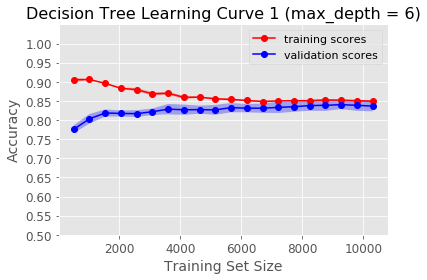

In [142]:
def plot_learning_curve_dt1():
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(DecisionTreeClassifier(max_depth=6),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Learning Curve 1 (max_depth = 6)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Decision Tree Learning Curve 1 (max_depth = 6)', tight_layout=True)
    
plot_learning_curve_dt1()

Saving figure Decision Tree Learning Curve 2 (max_depth = 10)


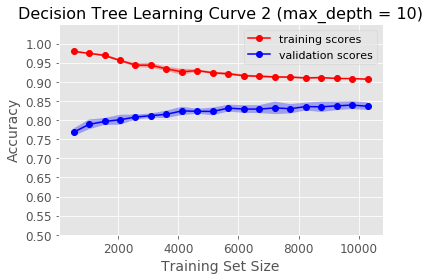

In [143]:
def plot_learning_curve_dt2():
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(DecisionTreeClassifier(max_depth=10),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('Decision Tree Learning Curve 2 (max_depth = 10)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('Decision Tree Learning Curve 2 (max_depth = 10)', tight_layout=True)
    
plot_learning_curve_dt2()

In [144]:
dt_clf = DecisionTreeClassifier(max_depth = 10, random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [145]:
test_score = dt_clf.score(X_test, y_test)
print ('Decision Tree Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

Decision Tree Model Prediction Accuracy on Test Data: 0.0000


In [30]:
dt_clf = DecisionTreeClassifier(max_depth = 6, random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [31]:
test_score = dt_clf.score(X_test, y_test)
print ('Decision Tree Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

Decision Tree Model Prediction Accuracy on Test Data: 0.7208


# MLPClassifier

# data normalizing is important for MLPClassifier

In [32]:
# parameters={
# 'learning_rate': ["constant", "invscaling", "adaptive"],
# 'hidden_layer_sizes': [(100,1), (100,2), (100,3)],
# 'alpha': [10.0 ** -np.arange(1, 7)],
# 'activation': ["logistic", "relu", "Tanh"]
# }

# clf = gridSearchCV(estimator=MLPClassifier,param_grid=parameters,n_jobs=-1,verbose=2,cv=10)

Saving figure MLP Complexity Curve 1 (hidden_layer_sizes)


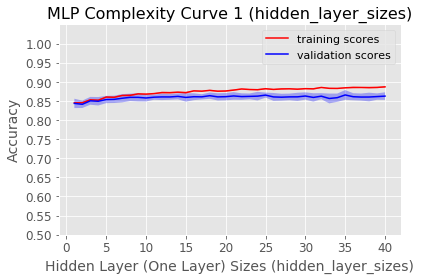

In [146]:
# first complexity curve on hidden layer size with default parameters
def plot_complexity_curve_mlp1():
    param_name="hidden_layer_sizes"
    param_range=range(1,41)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r', dots = False)
    plot_curve(param_range, val_test, label='validation scores', color = 'b', dots = False)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Hidden Layer (One Layer) Sizes (hidden_layer_sizes)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 1 (hidden_layer_sizes)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 1 (hidden_layer_sizes)', tight_layout=True)
    
plot_complexity_curve_mlp1()

Saving figure MLP Complexity Curve 2 (hidden_layer numbers)


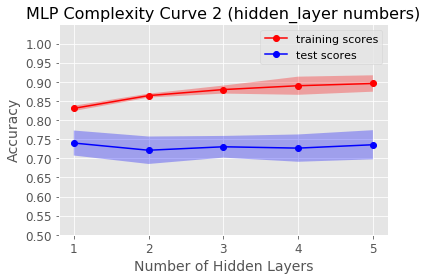

In [34]:
def plot_complexity_curve_mlp2():
    val_train_result = [np.array([])]
    val_train_std = np.array([])
    val_test_result = np.array([])
    val_test_std = np.array([])
    sizes = [(10,), (10, 10), (10, 10, 10), (10, 10, 10, 10), (10, 10, 10, 10, 10)]
    for i in sizes:
        clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes = i, random_state=0)
        results = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True)

        val_train_result = np.append(val_train_result, results['train_score'].mean())
        val_test_result = np.append(val_test_result, results['test_score'].mean())
        val_train_std = np.append(val_train_std, results['train_score'].std())
        val_test_std = np.append(val_test_std, results['test_score'].std())                     
        
    lines1 = plt.plot(range(1,6),val_train_result , 'o-', color = 'r', label='training scores')
    lines2 = plt.plot(range(1,6),val_test_result , 'o-', color = 'b', label='test scores')

    plt.fill_between(range(1,6), val_train_result - val_train_std, val_train_result + val_train_std, edgecolor='none',
                     facecolor=lines1[0].get_color(), alpha=0.3)
    plt.fill_between(range(1,6), val_test_result - val_test_std, val_test_result + val_test_std, edgecolor='none',
                     facecolor=lines2[0].get_color(), alpha=0.3)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(range(1, 6))
    plt.xlabel('Number of Hidden Layers'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 2 (hidden_layer numbers)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 2 (hidden_layer numbers)', tight_layout=True)
    
plot_complexity_curve_mlp2()

Saving figure MLP Complexity Curve 3 (max_iter)


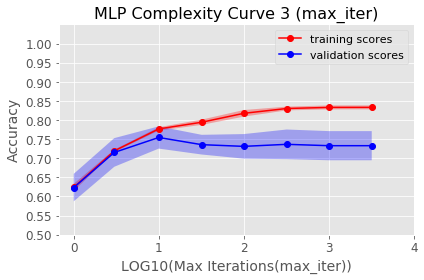

In [35]:
def plot_complexity_curve_mlp3():
    param_name="max_iter"
    param_range=[1, 3, 10, 32, 100, 320, 1000, 3200]
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(range(0, 5))
    plt.xlabel('LOG10(Max Iterations(max_iter))'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 3 (max_iter)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Complexity Curve 3 (max_iter)', tight_layout=True)
    
plot_complexity_curve_mlp3()

Saving figure MLP Complexity Curve 4 (alpha)


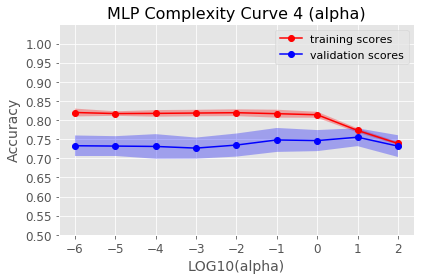

In [36]:
def plot_complexity_curve_mlp4():
    param_name="alpha"
    param_range=[1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10, 100]
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, max_iter = 100, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('LOG10(alpha)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 4 (alpha)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Complexity Curve 4 (alpha)', tight_layout=True)
    
plot_complexity_curve_mlp4()

Saving figure MLP Complexity Curve 5 (hidden_layer_sizes again)


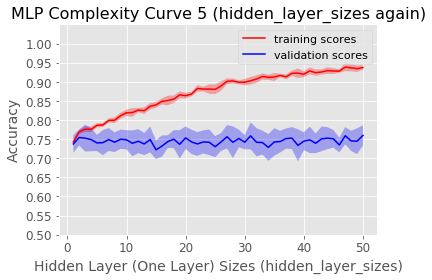

In [37]:
# to double check all parameters
def plot_complexity_curve_mlp5():
    param_name="hidden_layer_sizes"
    param_range=range(1,51)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', alpha = 1e0, max_iter = 300, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r', dots = False)
    plot_curve(param_range, val_test, label='validation scores', color = 'b', dots = False)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Hidden Layer (One Layer) Sizes (hidden_layer_sizes)'); plt.ylabel('Accuracy')
    plt.title('MLP Complexity Curve 5 (hidden_layer_sizes again)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('MLP Complexity Curve 5 (hidden_layer_sizes again)', tight_layout=True)

plot_complexity_curve_mlp5()

Saving figure MLP Learning Curve 1 (relu)


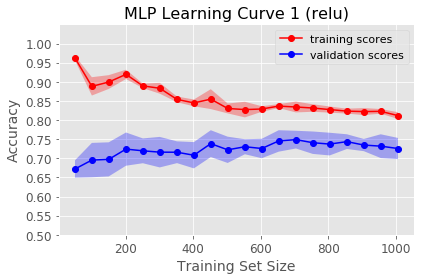

In [38]:
def plot_learning_curve_mlp():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300, activation = 'relu', random_state=1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve 1 (relu)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve 1 (relu)', tight_layout=True)
    
plot_learning_curve_mlp()

Saving figure MLP Learning Curve 2 (logistic)


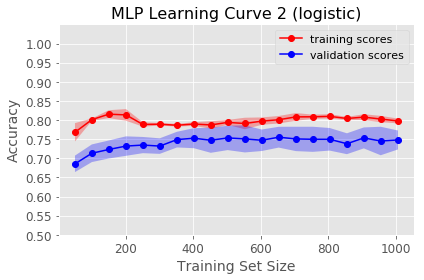

In [39]:
def plot_learning_curve_mlp2():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300, activation = 'logistic',random_state=1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve 2 (logistic)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve 2 (logistic)', tight_layout=True)
    
plot_learning_curve_mlp2()

Saving figure MLP Learning Curve 3 (max_iter)(relu)


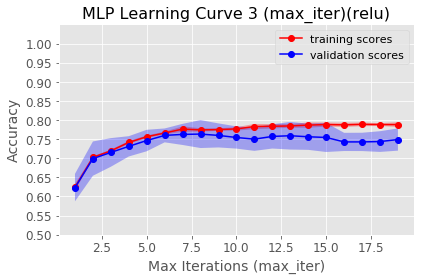

In [40]:
def plot_learning_curve_mlp3():
    param_name="max_iter"
    param_range=range(1, 20, 1)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Max Iterations (max_iter)'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve 3 (max_iter)(relu)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve 3 (max_iter)(relu)', tight_layout=True)

plot_learning_curve_mlp3()

Saving figure MLP Learning Curve 4 (max_iter)(logistic)


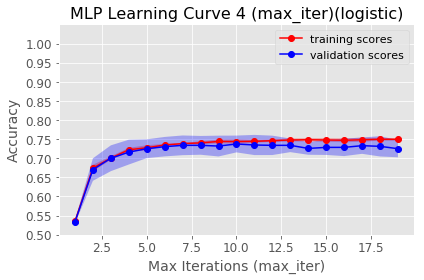

In [41]:
def plot_learning_curve_mlp4():
    param_name="max_iter"
    param_range=range(1, 20, 1)
    val_train, val_test = validation_curve(MLPClassifier(solver='lbfgs', hidden_layer_sizes=10, activation = 'logistic', random_state=0),
                                           X_train, y_train,
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Max Iterations (max_iter)'); plt.ylabel('Accuracy')
    plt.title('MLP Learning Curve 4 (max_iter)(logistic)', fontsize=16)
    plt.legend(fontsize=11)
    #plt.grid()
    save_fig('MLP Learning Curve 4 (max_iter)(logistic)', tight_layout=True)

plot_learning_curve_mlp4()

In [42]:
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300,random_state=0)
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [43]:
test_score = mlp_clf.score(X_test, y_test)
print ('ANN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

ANN Model Prediction Accuracy on Test Data: 0.7729


In [44]:
mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e0, 
                        hidden_layer_sizes=10, max_iter = 300,activation = 'logistic', random_state=0)
mlp_clf.fit(X_train, y_train)

MLPClassifier(activation='logistic', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=10, learning_rate='constant',
       learning_rate_init=0.001, max_iter=300, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [45]:
test_score = mlp_clf.score(X_test, y_test)
print ('ANN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

ANN Model Prediction Accuracy on Test Data: 0.7771


# AdaBoostClassifier

Saving figure AdaBoost Complexity Curve 1 (Tree max_depth)


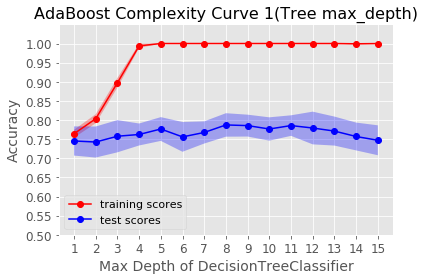

In [46]:
def plot_complexity_curve_bdt1():
    val_train_result = [np.array([])]
    val_train_std = np.array([])
    val_test_result = np.array([])
    val_test_std = np.array([])
    sizes = range(1, 16)
    for i in sizes:
        clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),learning_rate=1,algorithm="SAMME")
        results = cross_validate(clf, X_train, y_train, cv=10, return_train_score=True)

        val_train_result = np.append(val_train_result, results['train_score'].mean())
        val_test_result = np.append(val_test_result, results['test_score'].mean())
        val_train_std = np.append(val_train_std, results['train_score'].std())
        val_test_std = np.append(val_test_std, results['test_score'].std())                     
        
    lines1 = plt.plot(sizes,val_train_result , 'o-', color = 'r', label='training scores')
    lines2 = plt.plot(sizes,val_test_result , 'o-', color = 'b', label='test scores')

    plt.fill_between(sizes, val_train_result - val_train_std, val_train_result + val_train_std, edgecolor='none',
                     facecolor=lines1[0].get_color(), alpha=0.3)
    plt.fill_between(sizes, val_test_result - val_test_std, val_test_result + val_test_std, edgecolor='none',
                     facecolor=lines2[0].get_color(), alpha=0.3)
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(sizes)
    plt.xlabel('Max Depth of DecisionTreeClassifier'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Complexity Curve 1(Tree max_depth)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Complexity Curve 1 (Tree max_depth)', tight_layout=True)
    
plot_complexity_curve_bdt1()

Saving figure AdaBoost Complexity Curve 2 (n_estimators)


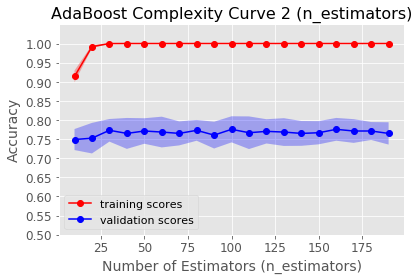

In [47]:
def plot_complexity_curve_bdt2():
    param_name="n_estimators"
    param_range=range(10, 200, 10)
    val_train, val_test = validation_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                           learning_rate=1,algorithm="SAMME"),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Number of Estimators (n_estimators)'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Complexity Curve 2 (n_estimators)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Complexity Curve 2 (n_estimators)', tight_layout=True)

plot_complexity_curve_bdt2()

Saving figure AdaBoost Learning Curve 1


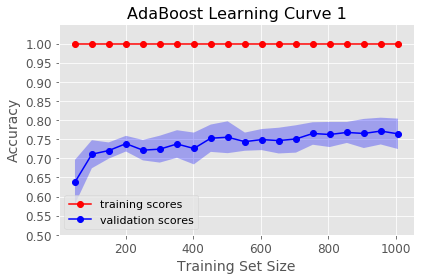

In [48]:
def plot_learning_curve_bdt():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                                                     n_estimators=100,learning_rate=1,algorithm="SAMME"),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Learning Curve 1', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Learning Curve 1', tight_layout=True)
    
plot_learning_curve_bdt()

Saving figure AdaBoost Learning Curve 2 (smaller learning rate)


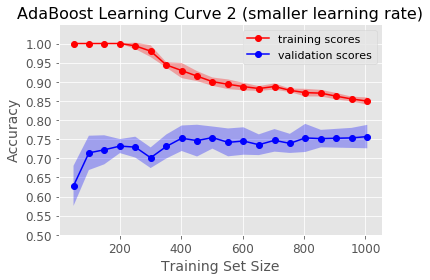

In [49]:
def plot_learning_curve_bdt2():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                                                     n_estimators=100,learning_rate=0.1,algorithm="SAMME"),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Learning Curve 2 (smaller learning rate)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Learning Curve 2 (smaller learning rate)', tight_layout=True)
    
plot_learning_curve_bdt2()

Saving figure AdaBoost Learning Curve 3 (n_estimators)


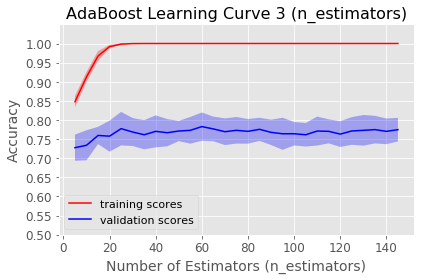

In [50]:
def plot_learning_curve_bdt3():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="n_estimators"
    param_range=range(5, 150, 5)
    val_train, val_test = validation_curve(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),
                                           learning_rate=1,algorithm="SAMME"),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', dots = False, color = 'r')
    plot_curve(param_range, val_test, label='validation scores', dots = False, color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Number of Estimators (n_estimators)'); plt.ylabel('Accuracy')
    plt.title('AdaBoost Learning Curve 3 (n_estimators)', fontsize=16)    
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('AdaBoost Learning Curve 3 (n_estimators)', tight_layout=True)
    
plot_learning_curve_bdt3()

In [51]:
bdt_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=100,
    learning_rate=1,
    algorithm="SAMME")
bdt_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=100, random_state=None)

In [52]:
test_score = bdt_clf.score(X_test, y_test)
print ('AdaBoost Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

AdaBoost Model Prediction Accuracy on Test Data: 0.8187


In [53]:
bdt_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=100,
    learning_rate=0.1,
    algorithm="SAMME")
bdt_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=100, random_state=None)

In [54]:
test_score = bdt_clf.score(X_test, y_test)
print ('AdaBoost Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

AdaBoost Model Prediction Accuracy on Test Data: 0.7667


# SVC

Saving figure SVC Complexity Curve (rbf) 1 (C)


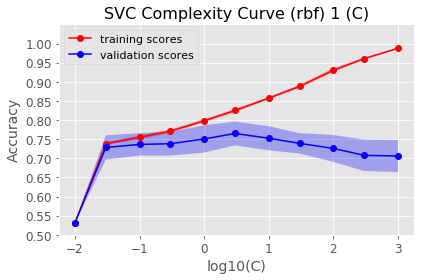

In [55]:
def plot_complexity_curve_svm1():
    param_name="C"
    param_range=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'rbf'),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('log10(C)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (rbf) 1 (C)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (rbf) 1 (C)', tight_layout=True)
    
plot_complexity_curve_svm1()

Saving figure SVC Complexity Curve (rbf) 2 (gamma)


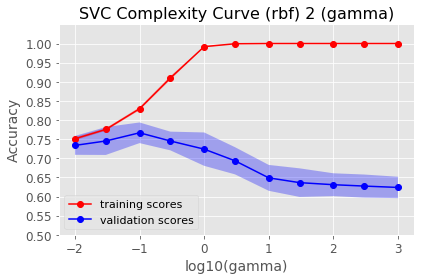

In [56]:
def plot_complexity_curve_svm2():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="gamma"
    param_range=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'rbf', C = 3),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('log10(gamma)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (rbf) 2 (gamma)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (rbf) 2 (gamma)', tight_layout=True)
    
plot_complexity_curve_svm2()

Saving figure SVC Learning Curve (rbf)


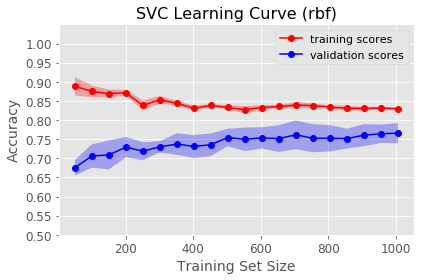

In [57]:
def plot_learning_curve_svm1():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(SVC(kernel= 'rbf', C = 3, gamma = 0.1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('SVC Learning Curve (rbf)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Learning Curve (rbf)', tight_layout=True)
    
plot_learning_curve_svm1()

Saving figure SVC Complexity Curve (poly) 1 (degree)


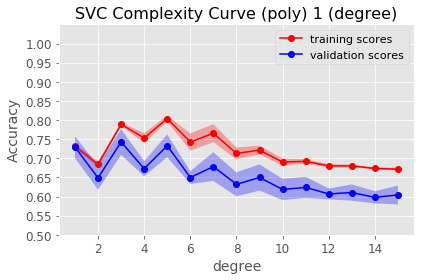

In [58]:
def plot_complexity_curve_svm3():
    param_name="degree"
    param_range=range(1, 16)
    val_train, val_test = validation_curve(SVC(kernel= 'poly'),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('degree'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (poly) 1 (degree)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (poly) 1 (degree)', tight_layout=True)
    
plot_complexity_curve_svm3()

Saving figure SVC Complexity Curve (poly) 2 (C)


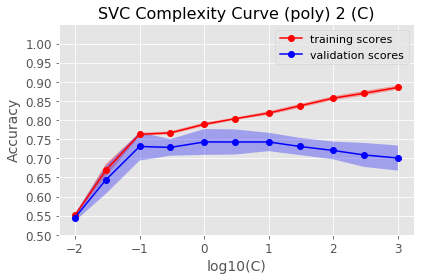

In [59]:
def plot_complexity_curve_svm4():
    param_name="C"
    param_range=[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000]
    val_train, val_test = validation_curve(SVC(kernel= 'poly', degree = 3),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('log10(C)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (poly) 2 (C)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (poly) 2 (C)', tight_layout=True)
    
plot_complexity_curve_svm4()

Saving figure SVC Complexity Curve (poly) 3 (gamma)


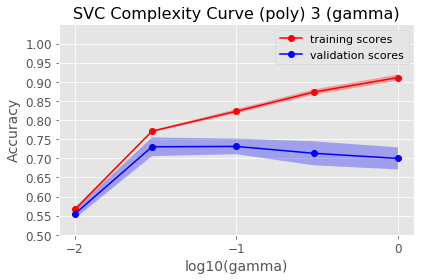

In [60]:
def plot_complexity_curve_svm5():
    #train_sizes = np.linspace(0.1, 0.95, 18)
    param_name="gamma"
    param_range=[0.01, 0.03, 0.1, 0.3, 1]
    val_train, val_test = validation_curve(SVC(kernel= 'poly', C = 10, degree = 3),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(np.log10(param_range), val_train, label='training scores', color = 'r')
    plot_curve(np.log10(param_range), val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xticks(range(-2, 1))
    plt.xlabel('log10(gamma)'); plt.ylabel('Accuracy')
    plt.title('SVC Complexity Curve (poly) 3 (gamma)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Complexity Curve (poly) 3 (gamma)', tight_layout=True)
    
plot_complexity_curve_svm5()

Saving figure SVC Learning Curve (poly)


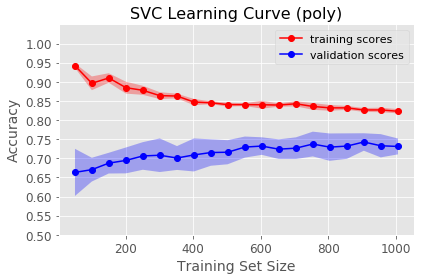

In [61]:
def plot_learning_curve_svm2():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(SVC(kernel= 'poly', C = 10, degree = 3, gamma = 0.1),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('SVC Learning Curve (poly)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('SVC Learning Curve (poly)', tight_layout=True)
    
plot_learning_curve_svm2()

In [62]:
svm_clf = SVC(kernel='rbf', C=3, gamma=0.1)
svm_clf.fit(X_train, y_train)

SVC(C=3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [63]:
test_score = svm_clf.score(X_test, y_test)
print ('SVM Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

SVM Model Prediction Accuracy on Test Data: 0.7583


In [64]:
svm_clf = SVC(kernel='poly', degree = 3, C=10, gamma = 0.1)
svm_clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [65]:
test_score = svm_clf.score(X_test, y_test)
print ('SVM Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

SVM Model Prediction Accuracy on Test Data: 0.7854


# KNN

Saving figure KNN Complexity Curve (n_neighbors)


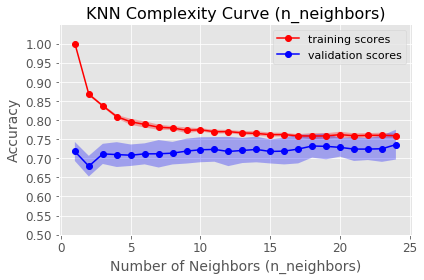

In [66]:
def plot_complexity_curve_knn():
    param_name="n_neighbors"
    param_range=range(1, 25)
    val_train, val_test = validation_curve(KNeighborsClassifier(),
                                           X_train, y_train, 
                                           param_name=param_name, param_range=param_range, cv=10)
    #print (val_train)
    plot_curve(param_range, val_train, label='training scores', color = 'r')
    plot_curve(param_range, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Number of Neighbors (n_neighbors)'); plt.ylabel('Accuracy')
    plt.title('KNN Complexity Curve (n_neighbors)', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('KNN Complexity Curve (n_neighbors)', tight_layout=True)
    
plot_complexity_curve_knn()

Saving figure KNN Learning Curve


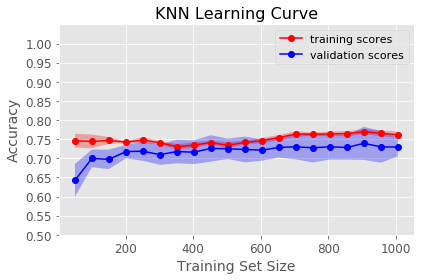

In [67]:
def plot_learning_curve_knn():
    train_sizes = np.linspace(0.05, 1, 20) 
    # if the train size is too small, training sample may only contain one class
    N_train, val_train, val_test = learning_curve(KNeighborsClassifier(n_neighbors=20),
                                                  X_train, y_train, train_sizes=train_sizes, cv=10)
    plot_curve(N_train, val_train, label='training scores', color = 'r')
    plot_curve(N_train, val_test, label='validation scores', color = 'b')
    lower = 0.5; upper = 1; interval = 0.05
    ytick_range = np.arange(lower, upper+interval, interval)
    plt.ylim(lower, upper+interval)
    plt.yticks(ytick_range)
    plt.xlabel('Training Set Size'); plt.ylabel('Accuracy')
    plt.title('KNN Learning Curve', fontsize=16)
    plt.legend(fontsize = 11)
    #plt.grid()
    save_fig('KNN Learning Curve', tight_layout=True)
    
plot_learning_curve_knn()

In [68]:
knn_clf = KNeighborsClassifier(n_neighbors=20)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [69]:
test_score = knn_clf.score(X_test, y_test)
print ('KNN Model Prediction Accuracy on Test Data: {:.4f}'.format(test_score))

KNN Model Prediction Accuracy on Test Data: 0.7354
